# Bouncing ball Network

In [1]:
import scipy.io
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import h5py
from ipywidgets import interact
import ipywidgets as widgets
plt.rcParams['figure.figsize'] = [10, 5]

import sys
#sys.path.append(r'C:\Users\CP\OneDrive\RU\Intern\Master')
sys.path.append(r'D:\RU\OneDrive\Intern\Master')

%matplotlib inline
from data.manipulate_data import *
from utils.plots import * 
from RTRBM_batches_in_funcs import RTRBM

### Import bouncing ball 

<ipython-input-2-00056607f3eb>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(create_BB(N_V = 16, T = 64, n_samples = 256, boundary = False))


<AxesSubplot:>

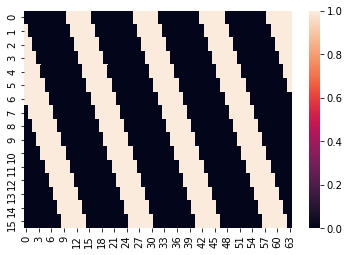

In [2]:
data = torch.tensor(create_BB(N_V = 16, T = 64, n_samples = 256, boundary = False))
N_V, T, n_sample = data.shape

sample = 2
sns.heatmap(data[:,:,sample])

### Train cRTRBM
Sparsity is only enforced on VH

In [3]:
n_epochs = 100
N_H = 8
crtrbm = RTRBM(data, N_H = N_H)

errors_epoch = torch.zeros(n_epochs)
HH_epoch = torch.zeros(N_H, N_H, n_epochs)
VH_epoch = torch.zeros(N_V, N_H, n_epochs)

lr = torch.linspace(1e-2, 1e-4, n_epochs)
for i in tqdm(range(n_epochs)):
    crtrbm.learn(
              spars_penalty=3e-5, x=2, sp=True,
              activationFunction=torch.sigmoid,
              learning_rate=lr[i], learning_rate_decay=False,
              momentum=0.85,
              weightcost=0.0002,
              CDk=10,
              n_epochs=1,
              batchsize=128,
              disable_tqdm=True)
    
    errors_epoch[i] = crtrbm.errors
    VH_epoch[:, :, i] = crtrbm.W.T
    HH_epoch[:, :, i] = crtrbm.W_acc

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:27<00:00,  1.48s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.55it/s]


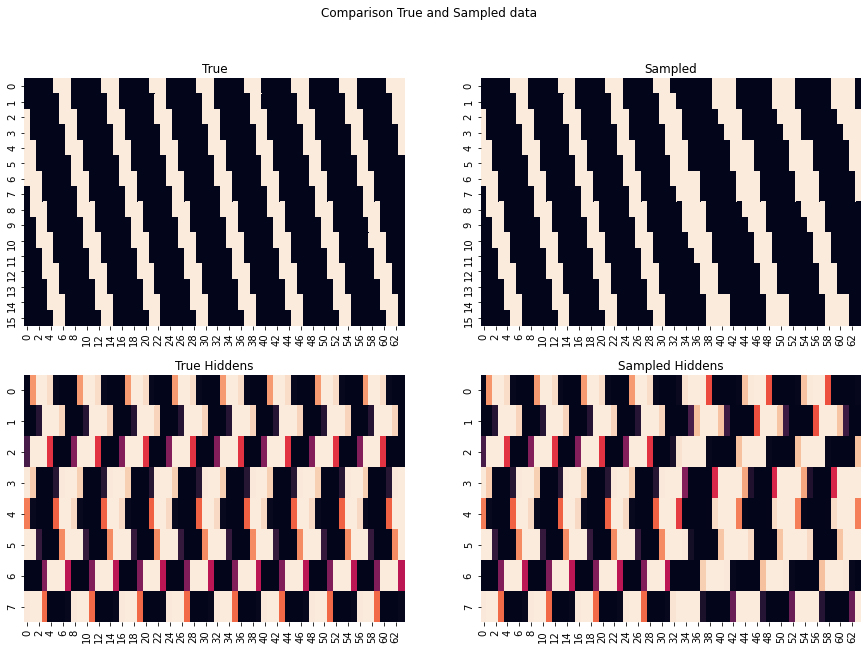

In [4]:
sample = np.random.randint(data.shape[2])
vt_sampled, rt_sampled = crtrbm.infer(data[:,:T//2, sample],
                                        pre_gibbs_k=1000,
                                        gibbs_k=100,
                                        mode=3,
                                        t_extra=0)

plot_true_sampled(data[:,:, sample], crtrbm.visible_to_hidden(data[:,:,sample].float()), vt_sampled, rt_sampled)

### Weight distributions and evolution per epoch

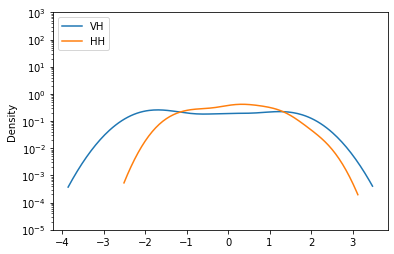

In [5]:
plot_weights_log_distribution_compare(crtrbm.W, crtrbm.W_acc, label1='VH', label2='HH', ymin=10e-6, ymax=1000)

Sparcity:	 0.0078125
Sparcity:	 0.0


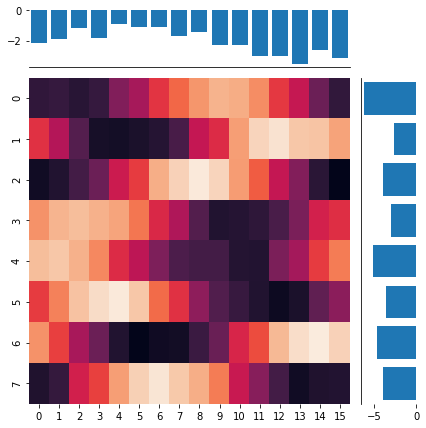

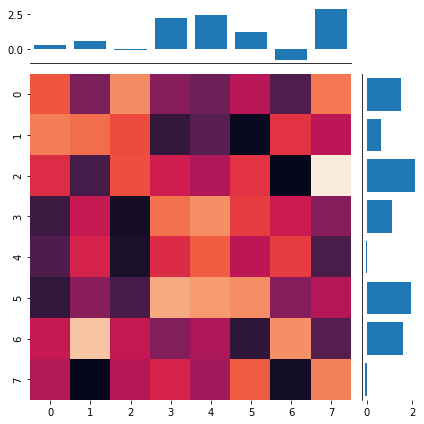

In [6]:
plot_weights_heatmap_sum(crtrbm.W, print_sparsity = True, th = 1e-3)
plot_weights_heatmap_sum(crtrbm.W_acc, print_sparsity = True, th = 1e-3)

### Pairwise interaction and local receptive fields

Just the matrix product with itself -> Almost all the information that the machine has learned is contained in the weights VH and HH (+ biases, but biases are mostly small against the weigths(<- STILL NEEDS TO BE VERIFIED)). Information in the visible layer is stored in a combination of W that is invariant under transformation of the hidden layer. The most simplest combination is just the product with itself -> $WW^T \rightarrow [(V ,H) * (H, V)]$.  The matrix product reflects correlations of the input configurations (v_train) used for the training of the machine.

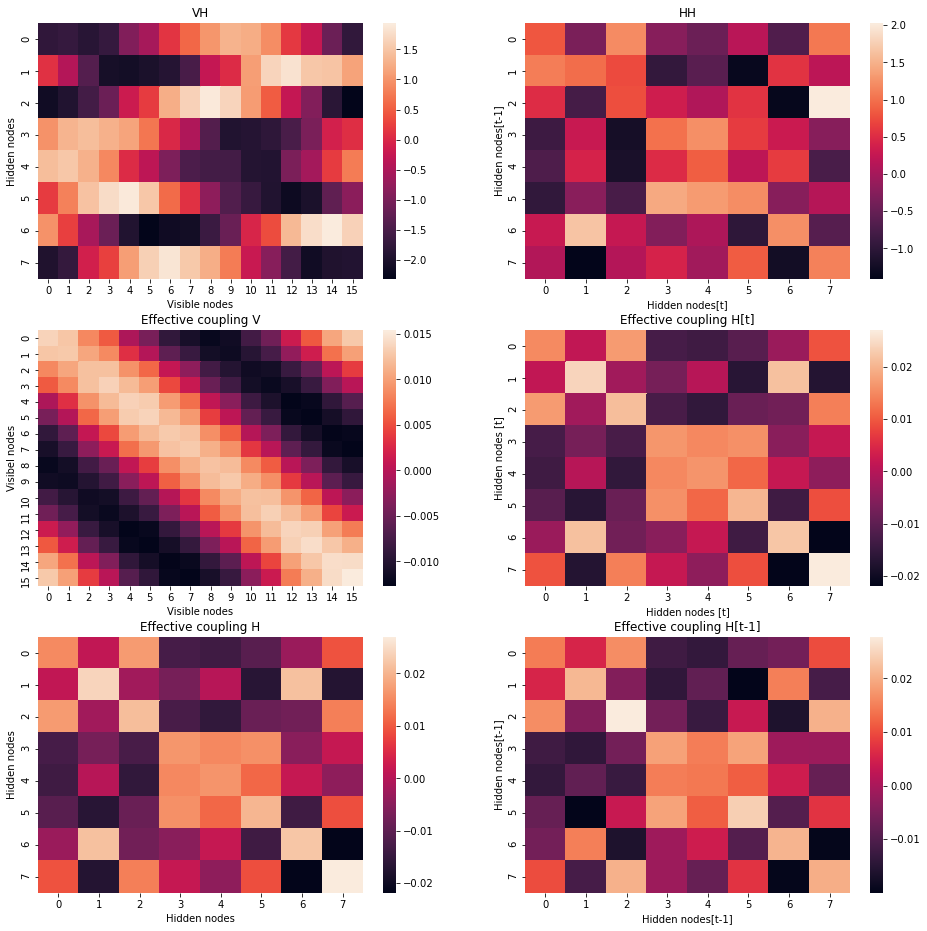

In [7]:
%matplotlib inline
plot_effective_coupling_VH_HH(crtrbm, data[:,:, sample].float())

Effective coupling $V_{vh}(t)$ $\rightarrow$ indicates that neurons are only facilitating its (nearest) neighbours, while its inhibitating the neurons that are further away off the diagonal. This would also explain the behaviour we observe in the plot_true_sampled figure (visible nodes that stay on is +- constantant over time), because we perform 100 gibbs samples and take the most probable one.

Furthermore, the effective coupling of $H_{vh}(t)$ computed from $VH$ shows similarities with the effective coupling of $H_{hh}(t)$ computed from $HH$. We think this is because both describe the relations between the hiddens. Moreover, the effective coupling of $H_{h}(t-1)$ shows also almost the same connectiviy between the hidden at t-1 as the hidden at t. 

We lose most dynamics if we look at the figure plot_true_sampled, we need a way to enforce more temporal dependencies (LSTM-RTRBM or update the HH matrix a different way such that it becomes more prominent in the RTRBM e.g. different learing rate or something).

<AxesSubplot:>

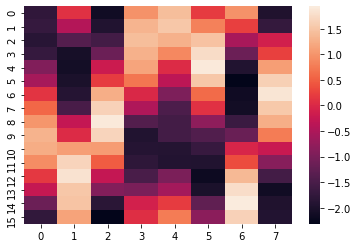

In [8]:
sns.heatmap(crtrbm.W.T)

<AxesSubplot:>

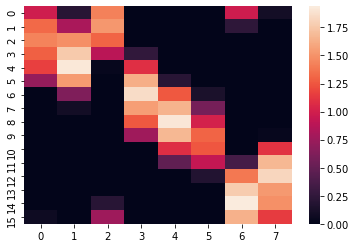

In [16]:
positions = torch.arange(1, N_V+1)
WM = torch.zeros(N_H)
VH = crtrbm.W.T.detach().clone()

VH[VH<0] = 0

for h in range(N_H):
    WM[h] = torch.sum(positions*VH[:,h]) / torch.sum(VH[:,h])

receptive_field = VH[:,torch.argsort(WM)]
sns.heatmap(receptive_field)

In [82]:
vt = data[:, :, sample]
rt = torch.bernoulli(crtrbm.visible_to_hidden(data[:, : ,sample].float())).int()
VH_temp = VH.detach().clone()

activation_magnitude = []
activation_visible_idx = []

for t in range(T):  
    rf_temp = np.array(receptive_field.detach().clone())
    
    idx = []
    mag = []
    
    for i in range(N_H):
        if rt[i,t] == 0:
            continue
        elif rt[i,t] == 1:
            idx_temp = np.where(rf_temp[:,i] != 0)
            idx.append(idx_temp)
            mag.append(rf_temp[idx_temp, i])
            
    activation_magnitude.append(np.hstack(mag)[0])
    activation_visible_idx.append(np.hstack(idx)[0])
            

<AxesSubplot:>

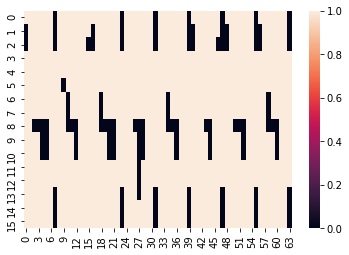

In [94]:
RF_visible = np.zeros([N_V, T])

for t in range(T):
    RF_visible[np.unique(activation_visible_idx[t]), t] = 1
    
sns.heatmap(RF_visible)

In [ ]:
%matplotlib notebook

import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation


snapshots_V = [ vt[:, t] for t in range(T) ] 
snapshots_H = [ rt[:, t] for t in range(T) ] 

snapshot_H_rf = [ np.unique(activation_visible_idx[t]) for t in range(T) ] 

#plt.clf()
fig, axes = plt.subplots(2,1,figsize=(3,9))
im_V = axes[0].imshow(np.reshape(snapshots_V[0], [N_V, 1]), interpolation='none', aspect='auto', \
                       vmin = VH.ravel().min(), vmax = VH.ravel().max())

im_H = axes[1].imshow(np.reshape(snapshots_H[0], [N_H, 1]), interpolation='none', aspect='auto', \
                       vmin = VH.ravel().min(), vmax = VH.ravel().max())

# add another axes at the top left corner of the figure
axtext = fig.add_axes([0.0,0.95,0.1,0.05])
# turn the axis labels/spines/ticks off
axtext.axis("off")

time = axtext.text(0.5,0.5, str(0), ha="left", va="top")
time1 = axtext.text(0.5,-18, str(0), ha="left", va="bottom")


#axes[0].set_xlabel(' # ')
axes[0].set_ylabel('Visibles')
axes[0].set_title('V')

#axes[1].set_xlabel(' # ')
axes[1].set_ylabel('Hiddens')
axes[1].set_title('H')

def animate_func(i):
    im_VH.set_array(np.reshape(snapshots_V[i], [N_V, 1]))
    im_HH.set_array(np.reshape(snapshots_H[i], [N_H, 1]))
    time.set_text(str(i))
    time1.set_text(str(i))

    return [im_VH, im_HH, time, time1]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = T,
                               interval = 1000, # in ms
                               blit=False)
                               
plt.show()

In [ ]:
snapshots_V = [ data[:,i, sample] for i in range(T) ] 

plt.imshow(np.reshape(snapshots_V[0], [N_V, 1]))

In [ ]:
snapshots_V

### Number of connection distribution

In [ ]:
threshold = 0.1
w = crtrbm.W
w[torch.abs(w) < threshold] = 0

n_connection_H = np.zeros(N_H)
for i in range(N_H):
    n_connection_H[i] = np.count_nonzero(w[i,:])
    
n_connection_V = np.zeros(N_V)
for i in range(N_V):
    n_connection_V[i] = np.count_nonzero(w[:,i])
    
sns.histplot(n_connection_H, binwidth=1, discrete=True)
plt.xlabel("Number of connections a hidden node has")
plt.ylabel("frequency")
plt.show()
sns.histplot(n_connection_V, binwidth=1, discrete=True)
plt.xlabel("Number of connections a visible node has")
plt.ylabel("frequency")
plt.show()

### Bipartite graph

In [ ]:
#w[w!=0] = 1
sns.heatmap(w)


### Closeness centrality

The closeness of a node is the distance to all other nodes in the graph normalized by the minimum distance possible. Where the distance is determined on how many edges you need to walk on to get to another node, where we count one edge as 1.

In [ ]:
# pip install networkx

import networkx as nx
from networkx.algorithms import bipartite
from scipy import sparse

# define scipy sparse matrix (=np.array, but in another format)
ws = sparse.csr_matrix(w)

# define graph in bipartite graph (RBM)
G = nx.algorithms.bipartite.matrix.from_biadjacency_matrix(ws)

# Check if G is connected via a bipartite graph
print(nx.is_connected(G))

# define the two node sets
bottom_nodes, top_nodes = bipartite.sets(G)

# Note the indexing, bottom_nodes = hiddens, top_nodes = visibles
print(list(bottom_nodes),list(top_nodes))

In [ ]:
# calculate closeness centrality
closeness_centrality = nx.algorithms.bipartite.centrality.closeness_centrality(G, bottom_nodes)
clustering = nx.algorithms.bipartite.clustering(G)

Cl_Ce_H = torch.zeros(N_H)
Cl_Ce_V = torch.zeros(N_V)
Cl_H = torch.zeros(N_H)
Cl_V = torch.zeros(N_V)

for i in range(N_H):
    Cl_Ce_H[i] = closeness_centrality[i]
    Cl_H[i] = clustering[i]
for i in range(N_V):
    Cl_Ce_V[i] = closeness_centrality[N_H + i]
    Cl_V[i] = clustering[N_H + i]
    
plt.plot(Cl_Ce_H, 'o')
plt.xlabel("Hidden")
plt.ylabel("Closeness centrality")
plt.show()

plt.plot(Cl_Ce_V, 'o')
plt.xlabel("Visibles")
plt.ylabel("Closeness centrality")
plt.show()

plt.plot(Cl_H, 'o')
plt.xlabel("Hidden")
plt.ylabel("Clustering")
plt.show()

plt.plot(Cl_V, 'o')
plt.xlabel("Visible")
plt.ylabel("Clustering")
plt.show()

In [ ]:
nx.draw_networkx(G, pos = nx.drawing.layout.bipartite_layout(G, bottom_nodes))

In [ ]:
mean_path_length_vv = torch.zeros(N_V)

for j in tqdm(range(N_V)):
    tot_path_length = 0
    for i in range(N_V+N_H):
        num = len(nx.shortest_path(G)[N_H + j][i])
        if num == 1:
            continue
        elif num % 2 == 0:
            continue
        else:
            # num is the number of nodes, num-1 is the number of edges
            tot_path_length += (num-1)
    mean_path_length_vv[j] = int(tot_path_length / (N_V-1))
mean_path_length_vv